<a href="https://colab.research.google.com/github/tgubbe/Real_Or_Fake_NLP/blob/main/Real_Or_Fake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Text to Determine Real or Fake News**

In this session, I will analyze the texts in news articles to determine real or fake news.

First, a variety of packages are installed in the session. These packages are the most common packages I use for analysis, so they are installed first.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

In addition, there are packages related to Natural Word Processing. These include the NLTK library and functions from the NLTK library, such as stopwords and word tokenization. These will be explained later in the session.

In [2]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Setting up the Data**

The data is imported into the session, with the real news and fake news data sets saved in separate data frames.

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
#The real and fake data sets are loaded into separate data frames.
real_df = pd.read_csv('/content/gdrive/My Drive/Datasets/True.csv')
fake_df = pd.read_csv('/content/gdrive/My Drive/Datasets/Fake.csv')

The real news and fake news data frames are viewed and inspected to get a feel for the data. Both data frames have title, text, subject, and date columns and contain no missing values.

In [5]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


A "Real_or_Fake" column is entered in both data frames, with "Real" or "Fake" values entered for each entry depending on the data frame. This will be useful in determining if the news is real or fake in the analysis.

In [9]:
real_df.insert(4, "Real_or_Fake", "Real")

In [10]:
fake_df.insert(4, "Real_or_Fake", "Fake")

The real and fake data frames are combined into one data frame (df). From here, further analysis can be explored.

In [11]:
df = real_df.append(fake_df)
df.head()

,title,text,subject,date,Real_or_Fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real


## **Exploratory Data Analysis**

Now that the data frames have been combined, a brief exploratory analysis is performed to investigate the data and find trends within the data.

First, missing values are double-checked before proceeding. As seen, there are no missing (null) values.

In [12]:
df.isnull().sum()

title           0
text            0
subject         0
date            0
Real_or_Fake    0
dtype: int64

Next, the data is checked for duplicates.

In [13]:
df.duplicated().sum()

209

Supposedly, there are 209 duplicates in the data. In order to see if this is true, the 'True' values are sorted by 'Title'.

In [14]:
df[df.duplicated()==True].sort_values('title')

,title,text,subject,date,Real_or_Fake
4439,'Nuclear option' fallout? More extreme U.S. ju...,WASHINGTON (Reuters) - A Republican-backed Sen...,politicsNews,"April 6, 2017",Real
11798,"After U.S. veto, U.N. General Assembly to meet...",UNITED NATIONS (Reuters) - The 193-member Unit...,worldnews,"December 19, 2017",Real
3251,Another U.S. appeals court refuses to revive T...,SAN FRANCISCO/WASHINGTON (Reuters) - President...,politicsNews,"June 12, 2017",Real
11776,Arab coalition says will keep Yemen port open;...,ADEN (Reuters) - The Saudi-led coalition fight...,worldnews,"December 20, 2017",Real
11753,Australia finds wreck of first Allied submarin...,SYDNEY (Reuters) - Australia has discovered th...,worldnews,"December 21, 2017",Real
...,...,...,...,...,...
12744,Vietnam police arrest ex-politburo member over...,HANOI (Reuters) - Vietnamese police on Friday ...,worldnews,"December 8, 2017",Real
1841,White House budget chief says any tax package ...,WASHINGTON (Reuters) - White House budget chie...,politicsNews,"September 7, 2017",Real
11746,"White, moldy and French: Russia's response to ...","VERKHNAYA PYSHMA/YEKATERINBURG, Russia (Reuter...",worldnews,"December 21, 2017",Real
11803,Zimbabwe's Mnangagwa promises zero tolerance i...,HARARE (Reuters) - Zimbabwean President Emmers...,worldnews,"December 20, 2017",Real


There does not actually appear to be duplicates in the data. The duplicates sum is ignored and the analysis will continue with the data as-is.

Next, a total_text_length column is added to the data by adding the total text length of both the title and the text. This value will be used to compare the fake and real news data frames.

In [15]:
#Combines the length of the title and text for each entry and enters the value in a separate column.
df['total_text_length'] = df['text'].apply(len)+df['title'].apply(len)
#Data frame is viewed to see if the function was applied correctly.
df.head()

,title,text,subject,date,Real_or_Fake,total_text_length
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real,4723
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real,4141
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real,2849
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real,2520
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real,5273


After creating the total_text_length column, the statistics of the column can be viewed.

In [16]:
df['total_text_length'].describe()

count    44898.000000
mean      2549.221413
std       2172.578772
min         30.000000
25%       1317.000000
50%       2269.000000
75%       3188.000000
max      51892.000000
Name: total_text_length, dtype: float64

The total_text_length statistics can also be grouped by real news or fake news for comparison.

In [17]:
df.groupby('Real_or_Fake').describe().transpose()

Real_or_Fake                     Fake          Real
total_text_length count  23481.000000  21417.000000
                  mean    2641.594268   2447.946398
                  std     2533.721790   1684.414608
                  min       30.000000     31.000000
                  25%     1529.000000    979.000000
                  50%     2258.000000   2285.000000
                  75%     3125.000000   3300.000000
                  max    51892.000000  29848.000000

Overall, there doesn't seem to be a huge difference in total text length between real news and fake news articles. We won't be able to determine if the news is real or fake based on the total text length alone.

A countplot is created to display the total counts for real news and fake news articles in the data frame. Overall, there are more fake news in the data, but not by a drastic amount.

Text(0.5, 1.0, 'Amount of Real News and Fake News')

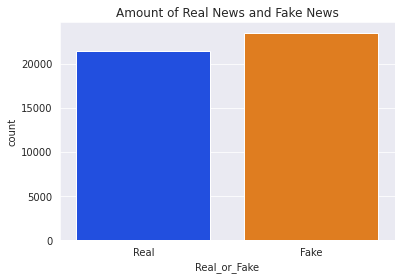

In [18]:
#Countplot for total amount of real news and fake news articles in the data.
sns.countplot(x = 'Real_or_Fake', data = df, palette = 'bright')
plt.title('Amount of Real News and Fake News')

Next, a counts table is created to see the total amount of articles by subject.

In [19]:
df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

To break it down further, a countplot visual is also created to view the total amount of articles by subject grouped by fake news and real news.

Text(0.5, 1.0, 'Total Count for Each Subject by Type of News')

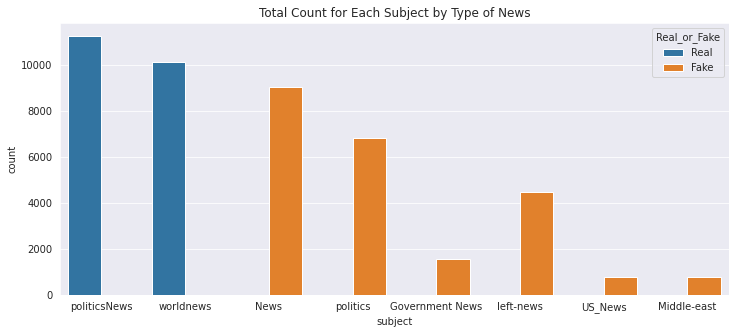

In [20]:
#Countplot for the breakdown of total articles by subject.
plt.figure(figsize = (12,5))
sns.countplot(x = 'subject', data = df, hue = 'Real_or_Fake')
plt.title('Total Count for Each Subject by Type of News')

A histogram of the length of text for real news and fake news is also created to compare the text length. I limited the x-axis to 15,000 words to make the graph more viewable. There were a few texts of over 15,000 words for both the real news and fake news entries, but the majority of entries contained less than 6,000 words.

(0.0, 15000.0)

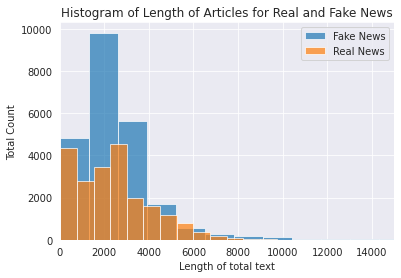

In [21]:
#Separates the data sets back to real or fake with the added length column.
real_plt = df[df['Real_or_Fake'] == "Real"]
fake_plt = df[df['Real_or_Fake'] == "Fake"]
#Two histograms created for real and fake news text lengths. The histograms are then combined on one chart.
plt.hist(fake_plt['total_text_length'], label = 'Fake News', bins = 40, alpha = 0.7)
plt.hist(real_plt['total_text_length'], label = 'Real News', bins = 40, alpha = 0.7)
#Displays title, legend, and the plot labels
plt.title('Histogram of Length of Articles for Real and Fake News')
plt.legend()
plt.xlabel('Length of total text')
plt.ylabel('Total Count')
#Sets x axis limit to 15,000 words. This is to view the most common text length a little closer. 
plt.xlim(0,15000)

## **Mutating the Data Sets**

Next, a 'total_text' column is added by combining the lengths of the 'title' and 'text' columns for each entry. This column will be used for further analysis in determining if an entry is real or fake.

In [22]:
#Combines the text from the 'title' and 'text' columns for both the real_df and fake_df data frames.
real_df['total_text'] = real_df['title']+real_df['text']
fake_df['total_text'] = fake_df['title']+fake_df['text']
#View the real_df data frame to see if the mutation worked.
real_df.head()

,title,text,subject,date,Real_or_Fake,total_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real,Trump wants Postal Service to charge 'much mor...


Now that the data frames are set, the 'total_text' column can be manipulated to prep the text for analysis. In order to do so, the punctuation, numerals, and single quotations are removed from the data, and the text is all lower case.

Below are two different methods of removing text. Both methods use the re package.

In [23]:
#Removes the punctuation from the real_df data frame.
real_df['total_text'] = real_df['total_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
#Removes the numerals from the real_df data frame.
real_df['total_text'] = real_df['total_text'].str.replace('\d+','')
#Removes the quotation marks from the real_df data frame.
real_df['total_text'] = real_df['total_text'].apply(lambda x: re.sub(r'\"', '', x))
#Lower case for all text.
real_df['total_text'] = real_df['total_text'].str.lower()

<ipython-input-23-b4b5544c94d2>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  real_df['total_text'] = real_df['total_text'].str.replace('\d+','')


The real_df data frame is quickly viewed to see if the text manipulation was successful.

In [24]:
real_df.head().transpose()

,0,1,2,3,4
title,"As U.S. budget fight looms, Republicans flip t...",U.S. military to accept transgender recruits o...,Senior U.S. Republican senator: 'Let Mr. Muell...,FBI Russia probe helped by Australian diplomat...,Trump wants Postal Service to charge 'much mor...
text,WASHINGTON (Reuters) - The head of a conservat...,WASHINGTON (Reuters) - Transgender people will...,WASHINGTON (Reuters) - The special counsel inv...,WASHINGTON (Reuters) - Trump campaign adviser ...,SEATTLE/WASHINGTON (Reuters) - President Donal...
subject,politicsNews,politicsNews,politicsNews,politicsNews,politicsNews
date,"December 31, 2017","December 29, 2017","December 31, 2017","December 30, 2017","December 29, 2017"
Real_or_Fake,Real,Real,Real,Real,Real
total_text,as us budget fight looms republicans flip thei...,us military to accept transgender recruits on ...,senior us republican senator let mr mueller do...,fbi russia probe helped by australian diplomat...,trump wants postal service to charge much more...


The same text manipulation is performed on the fake_df data frame.

In [25]:
#Removes the punctuation (- , .) from the fake_df data frame.
fake_df['total_text'] = fake_df['total_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
#Removes the numerals from the fake_df data frame.
fake_df['total_text'] = fake_df['total_text'].str.replace('\d+','')
#Removes the quotation marks from the fake_df data frame.
fake_df['total_text'] = fake_df['total_text'].apply(lambda x: re.sub(r'\"', '', x))
#Lower case for all text.
fake_df['total_text'] = fake_df['total_text'].str.lower()

<ipython-input-25-d2f1976c5e0a>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  fake_df['total_text'] = fake_df['total_text'].str.replace('\d+','')


## **Discovering the Most Common Bigrams**

Now that the text manipulation is successfully run, the data can now be searched for bigrams. Bigrams are a sequence of two consecutive elements from a string of tokens. An example would be a name ('John Doe') or phrase ('First Place').

First, a tokenizer needs to be implemented in order to break down the text into chunks. From this, a bigram model can be created to find the most common two consecutive tokens from the data frame.

A tokenizer and bigram model is first created for the real_df data frame.

In [26]:
#Creates a tokenizer for the text in the real_df data frame.
real_tokens = [w.lower() for c in real_df['total_text'] 
                    for s in nltk.sent_tokenize(c)
                    for w in nltk.word_tokenize(s)]
#Creates the bigrams for the real_df data frame based on the tokenizer above.
real_bigrams = nltk.FreqDist(nltk.bigrams(real_tokens))

Next, the stopwords are accounted for in the bigrams, with a frequenct counter added in to count the bigrams that do not contain stopwords. 

Stopwords are commonly used words that are usually removed in Natural Language Processing to help speed along the analysis. Stopwords include (but not limited to): a, an, and, he, her, and the.

By removing the stopwords, Python is able to find more unique bigrams instead of common ones, such as 'in the', 'is a', etc.

In [27]:
#Creates the set of stopwords in the English language.
stop = set([w.lower() for w in nltk.corpus.stopwords.words('english')])
#Creates a count list of the bigrams in the real_df data frame.
real_stopper = [((w1,w2),f) for ((w1,w2),f) in real_bigrams.most_common()
             if w1.isalpha() and w2.isalpha() and w1 not in stop 
             and w2 not in stop]

After removing the stopwords from the data frame and counting the frequency of the bigrams, the top 10 bigrams in the real_df data frame are viewed.

In [28]:
#Prints the top 10 bigrams in the real_df data frame. 
real_stopper[:10]

[(('united', 'states'), 12208),
 (('white', 'house'), 8805),
 (('donald', 'trump'), 8014),
 (('president', 'donald'), 5927),
 (('north', 'korea'), 5829),
 (('prime', 'minister'), 4154),
 (('new', 'york'), 3742),
 (('islamic', 'state'), 3563),
 (('told', 'reuters'), 3478),
 (('us', 'president'), 3463)]

In order to see the top 10 bigrams in a plot, the following code is run:

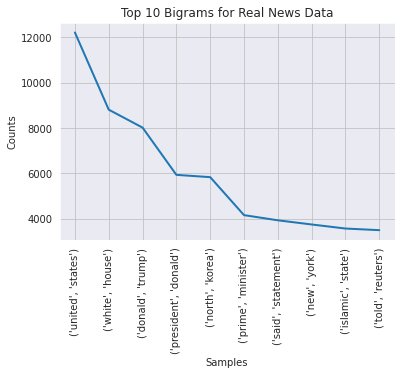

In [29]:
#Same as real_tokens, but adds .isalpha() function and makes sure words are not stopwords.
real_tokens_2 = [w.lower() for c in real_df['total_text'] 
                    for s in nltk.sent_tokenize(c)
                    for w in nltk.word_tokenize(s)
                    if w.isalpha() and w not in stop]
#Creates bigrams based on variable above.
real_bigrams_2 = nltk.FreqDist(nltk.bigrams(real_tokens_2))
#Plots the 10 most common bigrams in the real_df data frame.
real_bigrams_2.plot(10, title = 'Top 10 Bigrams for Real News Data')

The line plot helps see the distribution and drop off in the most-used bigrams. The top bigram use seems to level off after 'prime minister'. 

The top 10 bigrams for the fake_df data frame are also created and plotted. 

In [30]:
#Creates a tokenizer for the text in the real_df data frame.
fake_tokens = [w.lower() for c in fake_df['total_text'] 
                    for s in nltk.sent_tokenize(c)
                    for w in nltk.word_tokenize(s)]
#Creates the bigrams for the real_df data frame based on the tokenizer above.
fake_bigrams = nltk.FreqDist(nltk.bigrams(fake_tokens))
#Creates a count list of the bigrams in the fake_df data frame.
fake_stopper = [((w1,w2),f) for ((w1,w2),f) in fake_bigrams.most_common()
             if w1.isalpha() and w2.isalpha() and w1 not in stop 
             and w2 not in stop]
#Prints the top 10 bigrams in the fake_df data frame. 
fake_stopper[:10]

[(('donald', 'trump'), 12647),
 (('hillary', 'clinton'), 6872),
 (('white', 'house'), 6554),
 (('image', 'via'), 6192),
 (('united', 'states'), 6179),
 (('new', 'york'), 4269),
 (('president', 'obama'), 3857),
 (('president', 'trump'), 3831),
 (('fox', 'news'), 3412),
 (('barack', 'obama'), 2246)]

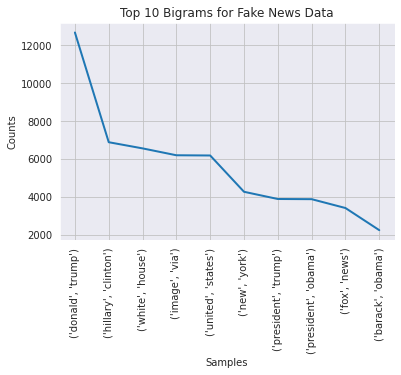

In [31]:
#Same as real_tokens, but adds .isalpha() function and makes sure words are not stopwords.
fake_tokens_2 = [w.lower() for c in fake_df['total_text'] 
                    for s in nltk.sent_tokenize(c)
                    for w in nltk.word_tokenize(s)
                    if w.isalpha() and w not in stop]
#Creates bigrams based on variable above.
fake_bigrams_2 = nltk.FreqDist(nltk.bigrams(fake_tokens_2))
#Plots the 10 most common bigrams in the real_df data frame.
fake_bigrams_2.plot(10, title = 'Top 10 Bigrams for Fake News Data')

Both data frames have some similar bigrams ('Donald Trump', 'United States' are a couple). However, it seems the real_df data frame may use more sources ('told reuters', 'said statement') while the fake_df data frame may use more images ('image via'). 

## **Prediction Model for Real and Fake News**

A prediction model will be created to predict if an article is real news or fake news.

First, the 'title' and 'text' strings will be combined into a 'total_text' column, just like what was done for the real_df and fake_df data frames earlier.

In [32]:
#Combines the text from the 'title' and 'text' columns for the df (combined) data frame.
df['total_text'] = df['title']+df['text']

The df data frame 'total_text' is manipulated the same way as the real_df and fake_df data frames.

In [33]:
#Removes the punctuation (- , .) from the df data frame.
df['total_text'] = df['total_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
#Removes the numerals from the df data frame.
df['total_text'] = df['total_text'].str.replace('\d+','')
#Removes the quotation marks from the df data frame.
df['total_text'] = df['total_text'].apply(lambda x: re.sub(r'\"', '', x))
#Lower case for all text.
df['total_text'] = df['total_text'].str.lower()

<ipython-input-33-3271cc6b7e1c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['total_text'] = df['total_text'].str.replace('\d+','')


Like before, the df data frame is viewed to see if the proper changes were performed. Since they were, the analysis continues.

In [34]:
df.head().transpose()

,0,1,2,3,4
title,"As U.S. budget fight looms, Republicans flip t...",U.S. military to accept transgender recruits o...,Senior U.S. Republican senator: 'Let Mr. Muell...,FBI Russia probe helped by Australian diplomat...,Trump wants Postal Service to charge 'much mor...
text,WASHINGTON (Reuters) - The head of a conservat...,WASHINGTON (Reuters) - Transgender people will...,WASHINGTON (Reuters) - The special counsel inv...,WASHINGTON (Reuters) - Trump campaign adviser ...,SEATTLE/WASHINGTON (Reuters) - President Donal...
subject,politicsNews,politicsNews,politicsNews,politicsNews,politicsNews
date,"December 31, 2017","December 29, 2017","December 31, 2017","December 30, 2017","December 29, 2017"
Real_or_Fake,Real,Real,Real,Real,Real
total_text_length,4723,4141,2849,2520,5273
total_text,as us budget fight looms republicans flip thei...,us military to accept transgender recruits on ...,senior us republican senator let mr mueller do...,fbi russia probe helped by australian diplomat...,trump wants postal service to charge much more...


Now that the df data is set up, a count vectorizor and train/test data sets are created to prep for the prediction model.

A copy of the df data frame is created (df_pred). That way, any changes made to the df_pred data frame will not change the df data frame. Once done, the 'Real_or_Fake' variable is mapped to 0 or 1 (0 = Real, 1 = Fake) for our binary classification model.

Next, the train/test data sets are created for the prediction model with a Count Vectorizor. A Count Vectorizor counts the number of times a word appears in the text.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer #For Count Vectorizor.
from sklearn.model_selection import train_test_split #For train/test split.

In [36]:
#A copy of the df data frame (df_pred) is created. The new data frame is then mapped so Real = 0 and Fake = 1 in the Real_or_Fake column.
df_pred = df.copy()
df_pred['Real_or_Fake'] = df_pred['Real_or_Fake'].map({'Real':0, 'Fake':1})
#X and y are created to return an NumPy array. 
X = df_pred['total_text'].values
y = df_pred['Real_or_Fake'].values
#A count vectorizor is created with English stop words. 
vector = CountVectorizer(stop_words = 'english')
#Fits/transforms the count vectorizor on the X variable
X = vector.fit_transform(X)
#Train and test data set created.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 30)

For the prediction model, a Multinomial Naive Bayes algorithm will be used to predict whether the text is part of real news or fake news. The Multinomial Naive Bayes model is a popular choice for Natural Language Processing since it's suitable for classification of discrete features (e.g. text). Please see the following link for more information:

https://towardsdatascience.com/multinomial-na%C3%AFve-bayes-for-documents-classification-and-natural-language-processing-nlp-e08cc848ce6

Below is the setup for the Multinomial Naive Bayes algorithm and the predictions based on the train and test sets.

In [37]:
#Creates and fits the Multinomial Naive Bayes algorithm
bayes_pred = MultinomialNB()
bayes_pred.fit(X_train, y_train)
#Creates predictions based on the model
predictions = bayes_pred.predict(X_test)

After creating the prediction model, a confusion matrix and classification report are created to see how well the model performed.


In [38]:
#Prints the confusion matrix and classification report for the bayes predictions.
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[5173  187]
 [ 263 5602]]


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5360
           1       0.97      0.96      0.96      5865

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



A confusion matrix plot is also created for a visualization on how well the model performed.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


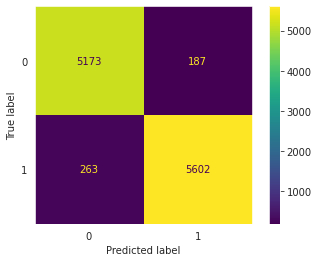

In [39]:
#Create confusion matrix plot.
plot_confusion_matrix(bayes_pred, X_test, y_test)
#Remove grid lines to clearly see the labels.
plt.grid(False)

Overall, the created prediction model did well predicting both real news and fake news, with a 96% total accuracy.

## **Conclusion**

In this session, two data sets displaying real news and fake news articles were analyzed to find the differences and predict whether an article has accurate information. First, the real and fake news data frames were explored for patterns and trends, with text manipulations performed to create bigrams and investigate the most common bigrams (two consecutive words) in the real news and fake news data frames.

Next, a Multinomial Naive Bayes prediction model was created to predict a real news or fake news article. The model was pretty accurate, predicting with a 96% accuracy.

Overall, the session was successful in identifying between the real news and fake news articles. If I were to investigate the data further, I would look into using other Natural Language Processing models such as BERT or XLNet.

Thank you for viewing my notebook!